# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [57]:
# Load the libraries as required.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib
import shap

c:\Users\Descus\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [ ]:
x = fires_dt.drop("area", axis=1)
y = fires_dt["area"]

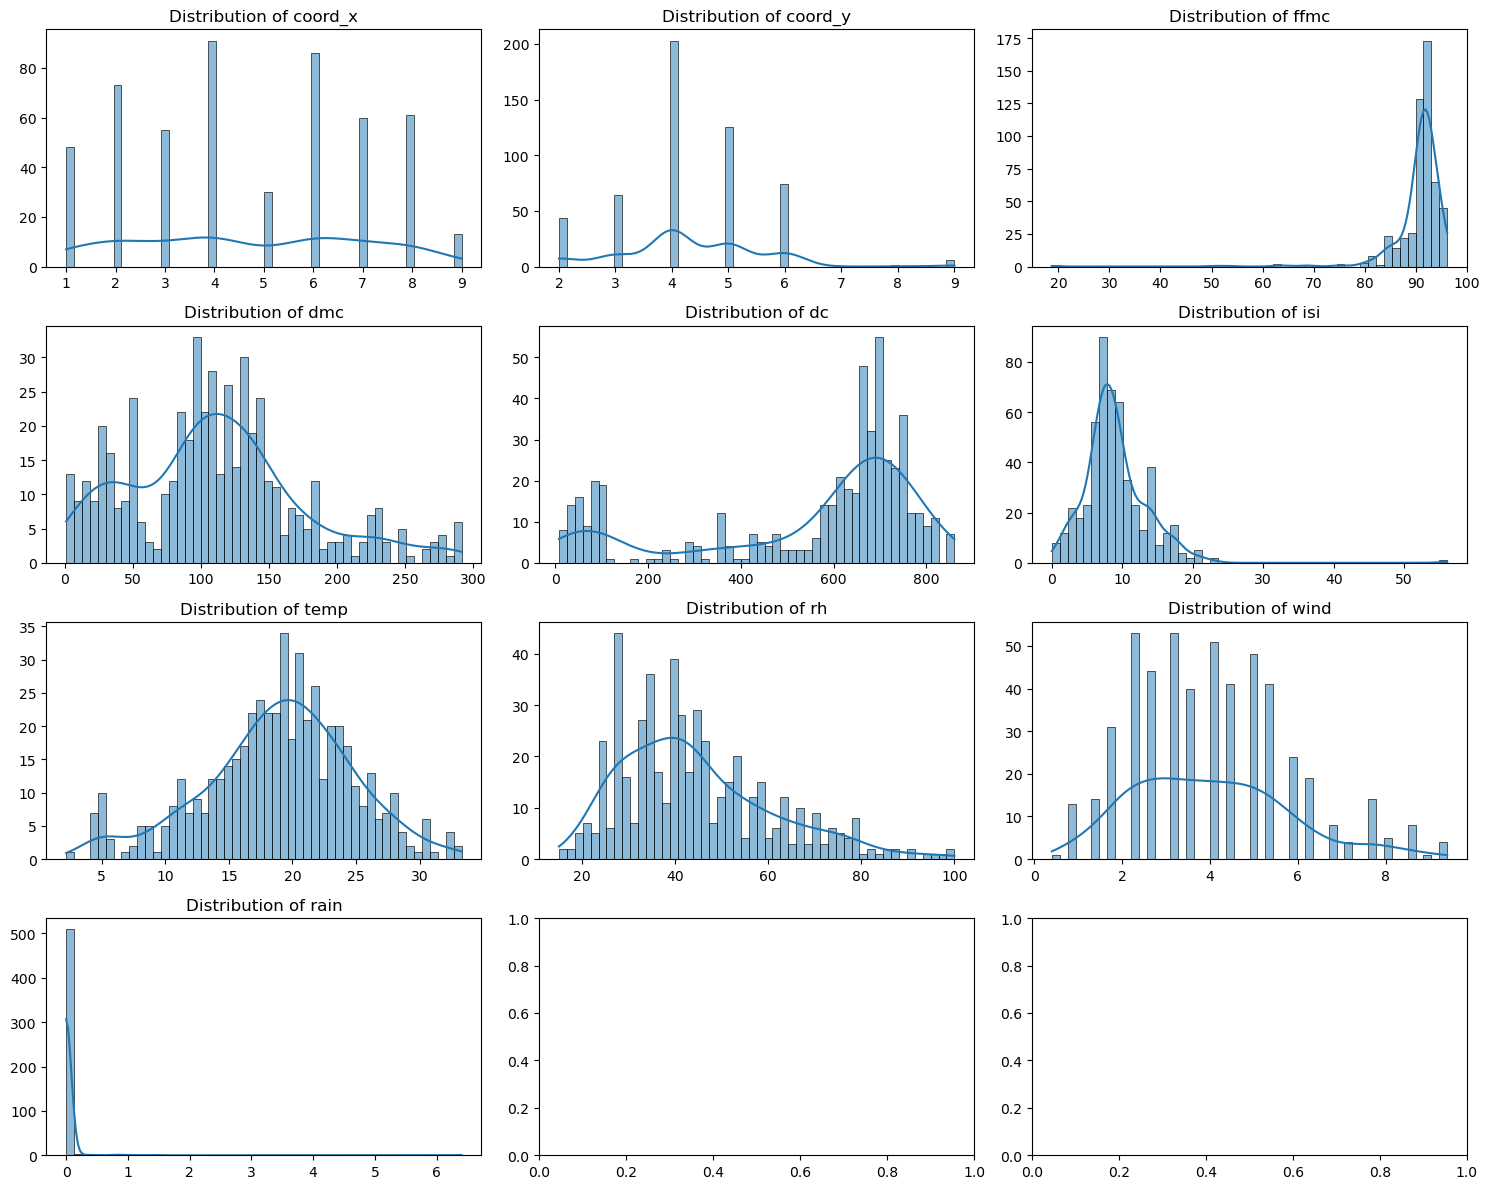

In [ ]:
categorical_features = ['month', 'day']
numerical_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# plotting histogram of numerical features to visually see and explore the data. For KNN it is recommended that skewness is addressed prior to 
# scaling as both the skewness and features of differing magnitures can affect the KNN algorithm distance calcuations. According to google search
# the following transformations can reduce skew: log, square root, box-cox, yeo-johnson and quantile.
n_cols = 3
n_rows = int(np.ceil(len(numerical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(fires_dt[col], kde=True, ax=axes[i], bins=50)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [18]:

preproc1 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [19]:
non_linear_features = ['ffmc', 'isi', 'rh', 'rain']
linear_features = ['coord_x', 'coord_y', 'dmc', 'dc', 'temp', 'wind']

yeojohnson_pipeline = Pipeline([
    ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

scaling_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preproc2 = ColumnTransformer(transformers=[
    ('yeojohnson_scaled', yeojohnson_pipeline, non_linear_features),
    ('regular_scaled', scaling_pipeline, linear_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# I'm not sure what the question "evaluate if the transformation is convenient". There is likely a way to automate the calculation of skewness for each numeric variable and 
# select a non-arbitrary cut off to which the non-linear transformation will apply. This additional step perhaps adds complexity and deeper knowledge of statistics and 
# domain knowledge of the underlying data.

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [22]:
# Pipeline A = preproc1 + Ridge baseline
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])

In [23]:
# Pipeline B = preproc2 + Ridge baseline
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

In [24]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [ ]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [51]:
param_grid_ridge = {
    'regressor__alpha': [1, 100, 1000, 1100, 1200, 1300, 1400, 1500, 2000]
}

param_grid_rf = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split': [2, 5]
}

In [30]:
def evaluate_pipeline(pipeline, param_grid, X_train, y_train, cv=5, name="Model"):
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    
    best_rmse = -grid.best_score_
    print(f"{name} Best CV RMSE: {best_rmse:.4f}")
    print(f"Best Params: {grid.best_params_}")
    
    return grid

In [52]:
grid_A = evaluate_pipeline(pipeline_A, param_grid_ridge, X_train, y_train, name="Pipeline A (preproc1 + Ridge baseline)")
grid_B = evaluate_pipeline(pipeline_B, param_grid_ridge, X_train, y_train, name="Pipeline B (preproc2 + Ridge baseline)")
grid_C = evaluate_pipeline(pipeline_C, param_grid_rf, X_train, y_train, name="Pipeline C (preproc1 + advanced model Random Forest)")
grid_D = evaluate_pipeline(pipeline_D, param_grid_rf, X_train, y_train, name="Pipeline D (preproc2 + advanced model Random Forest)")

Pipeline A (preproc1 + Ridge baseline) Best CV RMSE: 38.4609
Best Params: {'regressor__alpha': 1500}
Pipeline B (preproc2 + Ridge baseline) Best CV RMSE: 38.4665
Best Params: {'regressor__alpha': 1400}
Pipeline C (preproc1 + advanced model Random Forest) Best CV RMSE: 47.1779
Best Params: {'regressor__max_depth': 5, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Pipeline D (preproc2 + advanced model Random Forest) Best CV RMSE: 47.5973
Best Params: {'regressor__max_depth': 5, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


In [53]:
def test_model_performance(grid, X_test, y_test, label="Model"):
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{label} Test RMSE: {rmse:.4f}")
    return rmse

rmse_A = test_model_performance(grid_A, X_test, y_test, label="Pipeline A")
rmse_B = test_model_performance(grid_B, X_test, y_test, label="Pipeline B")
rmse_C = test_model_performance(grid_C, X_test, y_test, label="Pipeline C")
rmse_D = test_model_performance(grid_D, X_test, y_test, label="Pipeline D")

Pipeline A Test RMSE: 108.7050
Pipeline B Test RMSE: 108.6850
Pipeline C Test RMSE: 108.4844
Pipeline D Test RMSE: 108.3245


# Evaluate

+ Which model has the best performance?

Pipeline line D has the best model as it has the lowest RMSE out of the four.

# Export

+ Save the best performing model to a pickle file.

In [56]:
joblib.dump(grid_D.best_estimator_, 'best_model_pipeline_d.pkl')

['best_model_pipeline_d.pkl']

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

Prediction for test instance 0: 18.35


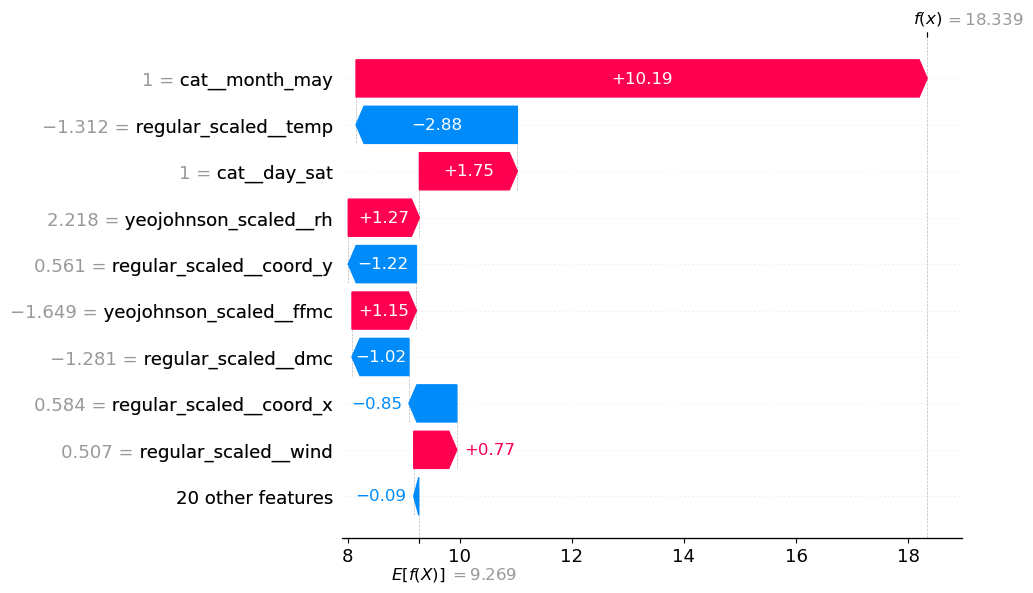

In [81]:
np.bool = bool
best_model = grid_D.best_estimator_
preprocessor = best_model.named_steps['preprocessing']
regressor = best_model.named_steps['regressor']

X_test_transformed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(regressor, X_test_transformed, feature_names=feature_names)

shap_values = explainer(X_test_transformed, check_additivity=False)

i = 0
print(f"Prediction for test instance {i}: {regressor.predict([X_test_transformed[i]])[0]:.2f}")
shap.plots.waterfall(shap_values[i])
plt.show()



In [ ]:
#downgrading packages does not work, "Pins seem to be invovled in the conflict. Currently pinned specs: -python=3.9"
shap.plots.beeswarm(shap_values)
plt.show()

In [85]:
shap_importances = np.abs(shap_values.values).mean(axis=0)
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()
feature_importance = sorted(zip(feature_names, shap_importances), key=lambda x: x[1], reverse=True)
print("Top 5 features by SHAP importance:")
for feat, val in feature_importance[:5]:
    print(f"{feat:<30} {val:.4f}")
print("\nBottom 5 features by SHAP importance:")
for feat, val in feature_importance[-5:]:
    print(f"{feat:<30} {val:.4f}")

Top 5 features by SHAP importance:
regular_scaled__dmc            3.5069
regular_scaled__temp           3.3850
regular_scaled__coord_x        2.0829
cat__day_sat                   1.2054
regular_scaled__coord_y        1.2008

Bottom 5 features by SHAP importance:
cat__month_aug                 0.0002
yeojohnson_scaled__rain        0.0000
cat__month_apr                 0.0000
cat__month_jan                 0.0000
cat__month_nov                 0.0000


The month of may, temperature and saturday are the most important features for the first observation's specific prediction. Impying that summer month with likely the high temperatures and a weekend when people are out camping/barbecuing is being used.

The most important features are DMC (a measure of moisture in organic soil layer), temperature, and location x/y coordinates. A day of the week is identified which may initially be thought to as noise but it could point out that human activity may lead to the start of forest fires. Example Saturday is a weekend and people may be out camping or barbecuing or conducting other such activities that can initiate fires during this day at a greater frequency during weekends compared to typical work days. The least are specific months (august, april, jan and november and scaled rain variable). This could mean that for this particular region, these months are representative of outside of the typical wildfire season. The rain feature may not be important because of lags between precipitation and other features better capture the potential for smoldering in soils which is specifically what DMC measures.

I would get rid of dummy variables from one hot encoding that don't contribute much (day and month) and other features with low SHAP values like rain. I would then recreate the pipelines using the reduced feature set, retrain, re-evaluate the model with the same metrics (i.e. in this case I used RMSE). If RMSE stays the same or decreases then it would be confirmed that those features were not useful. If RMSE goes up then those features are helpful and should be reintroduced. Through iterative re-rebuilding/retraining/revaluating we would arrive at a more optimal set of features needed for predictions.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.